### GROUP PROJECT MASTER

In [178]:
# import libraries and dependencies
import os
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
from dotenv import load_dotenv
import yfinance as yf
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension('plotly')
import hvplot.pandas

load_dotenv()
%matplotlib inline

In [203]:
# read in datasets
df_sp500 = pd.read_csv("DATA SOURCES/sp500_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_dowjones = pd.read_csv("DATA SOURCES/dowjones_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_nasdaq = pd.read_csv("DATA SOURCES/nasdaq_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_gold = pd.read_csv("DATA SOURCES/gold_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_silver = pd.read_csv("DATA SOURCES/silver_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
df_crudeoil = pd.read_csv("DATA SOURCES/crudeoil_historical.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
wti_df = pd.read_csv("DATA SOURCES/Crude_Oil_WTI.csv", index_col ="DATE", infer_datetime_format = True, parse_dates = True)


In [204]:
# set, pull and display data from YFinance
dxy_df = yf.download('DX-Y.NYB',
                       start='1980-01-01',
                       end='2021-01-31',
                       progress=False,
                       index_col ='Date',
                        interval ="1mo",
                       infer_datetime_format= True,
                       parse_dates = True,

)
dxy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,152.229996,153.889999,151.800003,152.720001,152.720001,0
1985-02-01,153.470001,164.720001,153.470001,160.410004,160.410004,0
1985-03-01,161.039993,163.830002,149.179993,149.179993,149.179993,0
1985-04-01,150.649994,153.160004,144.830002,149.699997,149.699997,0
1985-05-01,151.570007,154.520004,147.059998,147.860001,147.860001,0


## Data Cleaning

In [205]:
# drop unnecessary columns
df_sp500.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_dowjones.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_nasdaq.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_gold.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_silver.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
df_crudeoil.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)
dxy_df.drop(['Open', 'High','Low', 'Adj Close', 'Volume'],axis=1, inplace=True)

In [206]:
# rename columns to indicate index / symbol
df_sp500.rename(columns={"Price":"sp500"},inplace=True)
df_dowjones.rename(columns={"Price":"dowjones"},inplace=True)
df_nasdaq.rename(columns={"Price":"nasdaq"},inplace=True)
df_gold.rename(columns={"Price":"gold"},inplace=True)
df_silver.rename(columns={"Price":"silver"},inplace=True)
df_crudeoil.rename(columns={"Price":"crudeoil"},inplace=True)
dxy_df.rename(columns={'Close':'dxy_mthly'}, inplace= True)
wti_df.rename(columns={'MCOILWTICO':'wti_mthly'}, inplace = True)

## Park & Aidan's Datasets Combined

In [212]:
# combine datasets
df_commodities = pd.concat([df_sp500,df_dowjones,df_nasdaq,df_gold], join="inner", axis="columns")
df_commodities.head()

,sp500,dowjones,nasdaq,gold
Date,,,,
2021-01-01,"3,714.24","29,982.62","13,070.70","1,850.30"
2020-12-01,"3,756.07","30,606.48","12,888.28","1,895.10"
2020-11-01,"3,621.63","29,638.64","12,198.74","1,780.90"
2020-10-01,"3,269.96","26,501.60","10,911.59","1,887.20"
2020-09-01,"3,363.00","27,781.70","11,167.51","1,902.60"


In [213]:
# convert string (object) to float
df_commodities = df_commodities.apply(lambda x: x.str.replace(",",""))
df_commodities = df_commodities.astype('float')
df_commodities.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2021-01-01 to 1985-02-01
Freq: -1MS
Data columns (total 4 columns):
sp500       432 non-null float64
dowjones    432 non-null float64
nasdaq      432 non-null float64
gold        432 non-null float64
dtypes: float64(4)
memory usage: 16.9 KB


In [214]:
# combine datasets
oil_commodities_sp500 = pd.concat([df_commodities,df_silver,df_crudeoil,dxy_df, wti_df], join="inner", axis="columns")
oil_commodities_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2020-12-01 to 1986-01-01
Freq: -1MS
Data columns (total 8 columns):
sp500        420 non-null float64
dowjones     420 non-null float64
nasdaq       420 non-null float64
gold         420 non-null float64
silver       420 non-null float64
crudeoil     420 non-null float64
dxy_mthly    420 non-null float64
wti_mthly    420 non-null float64
dtypes: float64(8)
memory usage: 29.5 KB


In [215]:
oil_commodities_sp500.head()

,sp500,dowjones,nasdaq,gold,silver,crudeoil,dxy_mthly,wti_mthly
2020-12-01,3756.07,30606.48,12888.28,1895.1,26.412,48.52,89.940002,47.02
2020-11-01,3621.63,29638.64,12198.74,1780.9,22.593,45.34,91.870003,40.94
2020-10-01,3269.96,26501.60,10911.59,1887.2,23.799,35.79,94.040001,39.40
2020-09-01,3363.00,27781.70,11167.51,1902.6,23.627,40.22,93.889999,39.63
2020-08-01,3500.31,28430.05,11775.46,1986.5,28.756,42.61,92.139999,42.34


In [216]:
# calculate monthly returns
oil_commodities_return = oil_commodities_sp500.pct_change()

# calculate correlation
oil_commodities_corr = oil_commodities_return.corr()
oil_commodities_corr

,sp500,dowjones,nasdaq,gold,silver,crudeoil,dxy_mthly,wti_mthly
sp500,1.000000,0.959148,0.861442,-0.047171,0.168519,0.192896,-0.114657,0.090555
dowjones,0.959148,1.000000,0.772686,-0.065531,0.148147,0.171803,-0.084694,0.085366
nasdaq,0.861442,0.772686,1.000000,-0.033415,0.147108,0.159275,-0.057104,0.056424
gold,-0.047171,-0.065531,-0.033415,1.000000,0.709265,0.174997,-0.350768,0.067412
silver,0.168519,0.148147,0.147108,0.709265,1.000000,0.255584,-0.238662,0.159151
crudeoil,0.192896,0.171803,0.159275,0.174997,0.255584,1.000000,-0.189371,0.746044
dxy_mthly,-0.114657,-0.084694,-0.057104,-0.350768,-0.238662,-0.189371,1.000000,-0.108358
wti_mthly,0.090555,0.085366,0.056424,0.067412,0.159151,0.746044,-0.108358,1.000000


## Park's Data

In [217]:
prices_commodities = oil_commodities_sp500[["sp500","gold","silver","crudeoil"]].hvplot.line(title="Commodities Prices and S&P500", xlabel="Date", ylabel="Monthly Close Price")
prices_gold = oil_commodities_sp500[["sp500","gold"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
prices_silver = oil_commodities_sp500[["sp500","silver"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")
prices_crudeoil = oil_commodities_sp500[["sp500","crudeoil"]].hvplot.line(xlabel="Date", ylabel="Monthly Close Price")

In [218]:
df_rolling_corr = oil_commodities_return.rolling(window=12).corr().dropna()
df_rolling_corr.reset_index(inplace=True)
df_rolling_corr.rename(columns={"level_0":"Date"},inplace=True)
df_rolling_corr.set_index("Date",inplace=True)
df_rolling_corr.head(10)

,level_1,sp500,dowjones,nasdaq,gold,silver,crudeoil,dxy_mthly,wti_mthly
Date,,,,,,,,,
2019-12-01,sp500,1.000000,0.986655,0.984628,0.282747,0.652604,0.727857,-0.615385,0.270033
2019-12-01,dowjones,0.986655,1.000000,0.962062,0.174893,0.569161,0.745814,-0.550692,0.303696
2019-12-01,nasdaq,0.984628,0.962062,1.000000,0.354458,0.689535,0.686408,-0.630729,0.250396
2019-12-01,gold,0.282747,0.174893,0.354458,1.000000,0.704554,0.062932,-0.396420,-0.021521
2019-12-01,silver,0.652604,0.569161,0.689535,0.704554,1.000000,0.561272,-0.743051,0.442411
2019-12-01,crudeoil,0.727857,0.745814,0.686408,0.062932,0.561272,1.000000,-0.438583,0.755469
2019-12-01,dxy_mthly,-0.615385,-0.550692,-0.630729,-0.396420,-0.743051,-0.438583,1.000000,-0.391844
2019-12-01,wti_mthly,0.270033,0.303696,0.250396,-0.021521,0.442411,0.755469,-0.391844,1.000000
2019-11-01,sp500,1.000000,0.986423,0.983659,0.271794,0.653775,0.726302,-0.611275,0.262709


In [219]:
gold_corr = df_rolling_corr[df_rolling_corr['level_1'] == 'gold'].sp500
crude_oil_corr = df_rolling_corr[df_rolling_corr['level_1'] == 'crudeoil'].sp500
silver_corr = df_rolling_corr[df_rolling_corr['level_1'] == 'silver'].sp500
dowjones_corr = df_rolling_corr[df_rolling_corr['level_1'] == 'dowjones'].sp500

In [220]:
tickers = [
          "BTC-USD",
          "ETH-USD",
          "^GSPC"
          ]

df_crypto = yf.download(tickers,
start="1980-01-01",
end="2021-01-29",
progress=False,
interval = "1mo",
groupby = "ticker"
                )

In [221]:
df_crypto.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

In [222]:
df_crypto.rename(columns=
          {"BTC-USD":"btc",
             "ETH-USD":"eth",
             "^GSPC":"sp500",
            },inplace=True)

In [223]:
df_crypto.columns = df_crypto.columns.droplevel(level=0)

In [224]:
df_crypto.dropna(inplace=True)

In [225]:
df_crypto_return = df_crypto.pct_change()

In [226]:
df_crypto_corr = df_crypto_return.corr()

In [227]:
df_crypto_rolling_corr = df_crypto_return.rolling(window=12).corr().dropna()
df_crypto_rolling_corr.reset_index(inplace=True)
df_crypto_rolling_corr.set_index("Date",inplace=True)
df_crypto_rolling_corr.head()

,level_1,btc,eth,sp500
Date,,,,
2016-09-01,btc,1.000000,-0.177658,0.287968
2016-09-01,eth,-0.177658,1.000000,-0.207934
2016-09-01,sp500,0.287968,-0.207934,1.000000
2016-10-01,btc,1.000000,-0.199912,-0.077153
2016-10-01,eth,-0.199912,1.000000,-0.141507


In [228]:
btc_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == 'btc'].sp500
eth_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == 'eth'].sp500


In [229]:
def comm_correlation():
    comm_corr = oil_commodities_corr.hvplot.heatmap(title = "Commodities and Indices Correlation")    
    return comm_corr
def crypto_correlation():
    crypto_corr = df_crypto_corr.hvplot.heatmap(title = "Crytocurrencies and Indices Correlation")    
    return crypto_corr

list_of_commodities = ["gold","silver","crudeoil"]
def commodities_price(commodities):
    comm_price = oil_commodities_sp500[["sp500",commodities]].hvplot.line(title = f"Price of {commodities} and S&P500",
                                                                           xlabel="Date", ylabel="Monthly Close Price",ylim=(0,4000))
    return comm_price
def commodities_correlation(commodities):
    comm_corr = df_rolling_corr[df_rolling_corr['level_1'] == commodities].sp500
    return comm_corr.hvplot.line(title = f"{commodities} & S&P500 12 month Rolling Correlation", xlabel="Date", ylabel="Correlation")


list_of_crypto = ["btc","eth"]
def cryptocurrency_price(crypto):
    crypto_price = df_crypto[["sp500",crypto]].hvplot.line(title = f"Price of {crypto} and S&P500",
                                                                           xlabel="Date", ylabel="Monthly Close Price")
    return crypto_price
def cryptocurrency_corr(crypto):
    crypto_corr = df_crypto_rolling_corr[df_crypto_rolling_corr['level_1'] == crypto]
    return crypto_corr.sp500.hvplot.line(title = f"{crypto} and S&P500 12 month Rolling Correlation",
                                                                           xlabel="Date", ylabel="Correlation")


In [230]:
comm_summary = pn.Column("#S&P 500 and Commodities Summary", prices_commodities, comm_correlation())
crypto_summary = pn.Column("#S&P 500 and Cryptocurrencies Summary", df_crypto.hvplot.line(xlabel="Date", ylabel="Monthly Close Price"), crypto_correlation())
comm_analysis = pn.Column("#Commodities Analysis", interact(commodities_price, commodities=list_of_commodities), interact(commodities_correlation,commodities=list_of_commodities))
crypto_analysis = pn.Column("#Cryptocurrencies Analysis", interact(cryptocurrency_price, crypto=list_of_crypto), interact(cryptocurrency_corr,crypto=list_of_crypto))
panel1=pn.Tabs(
    ("Commodities Summary",comm_summary), ("Commodities Analysis",comm_analysis))
panel2=pn.Tabs(("Cryptocurrencies Summary", crypto_summary),("Cryptocurrencies Analysis",crypto_analysis))

### Dashboard

In [231]:
panel1.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(HeatMap)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column
                [0] Select(name='commodities', options=['gold', 'silver', ...], value='gold')
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive23059')
        [2] Column
            [0] Column
                [0] Select(name='commodities', options=['gold', 'silver', ...], value='gold')
            [1] Row
                [0] HoloViews(Curve, name='interactive23166')

## Aidan's Section

In [232]:
##rolling correlation NEEDNTO WORK ON STILL!
rolling_corr = oil_commodities_return.rolling(window=14).corr().dropna()
rolling_corr.reset_index(inplace=True)
rolling_corr.head()

,level_0,level_1,sp500,dowjones,nasdaq,gold,silver,crudeoil,dxy_mthly,wti_mthly
0,2019-10-01,sp500,1.000000,0.986176,0.983622,0.249393,0.627825,0.730069,-0.569593,0.280194
1,2019-10-01,dowjones,0.986176,1.000000,0.960607,0.135925,0.538810,0.745841,-0.495948,0.314018
2,2019-10-01,nasdaq,0.983622,0.960607,1.000000,0.320240,0.668676,0.685338,-0.583508,0.255700
3,2019-10-01,gold,0.249393,0.135925,0.320240,1.000000,0.712488,0.056940,-0.456869,-0.036459
4,2019-10-01,silver,0.627825,0.538810,0.668676,0.712488,1.000000,0.543362,-0.742357,0.420316


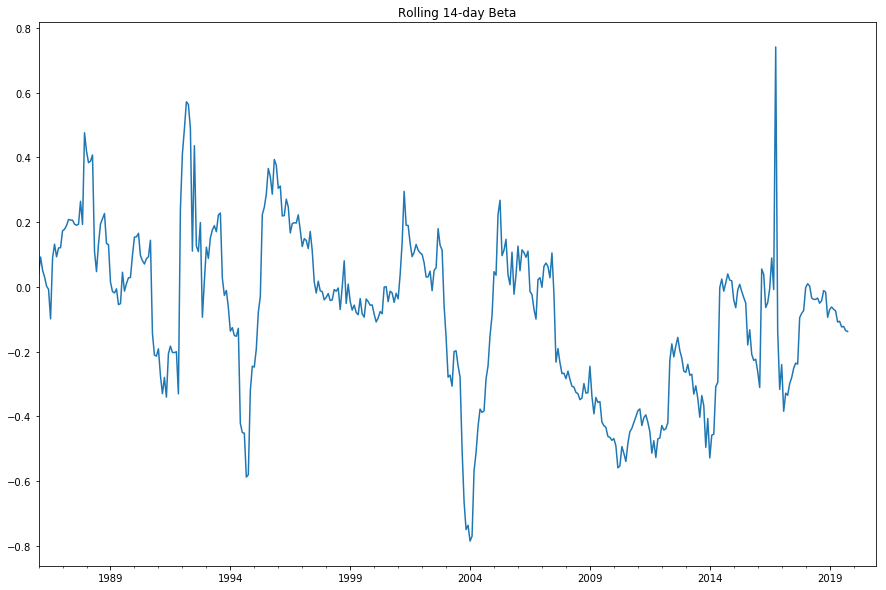

In [233]:
##Rolling beta S&P500 and USD
rolling_cov = oil_commodities_return['sp500'].rolling(window=14).cov(oil_commodities_return["dxy_mthly"])
rolling_var = oil_commodities_return['sp500'].rolling(window=14).var()
rolling_beta = rolling_cov / rolling_var
rolling_beta.plot(figsize=(15,10), title = "Rolling 14-day Beta")

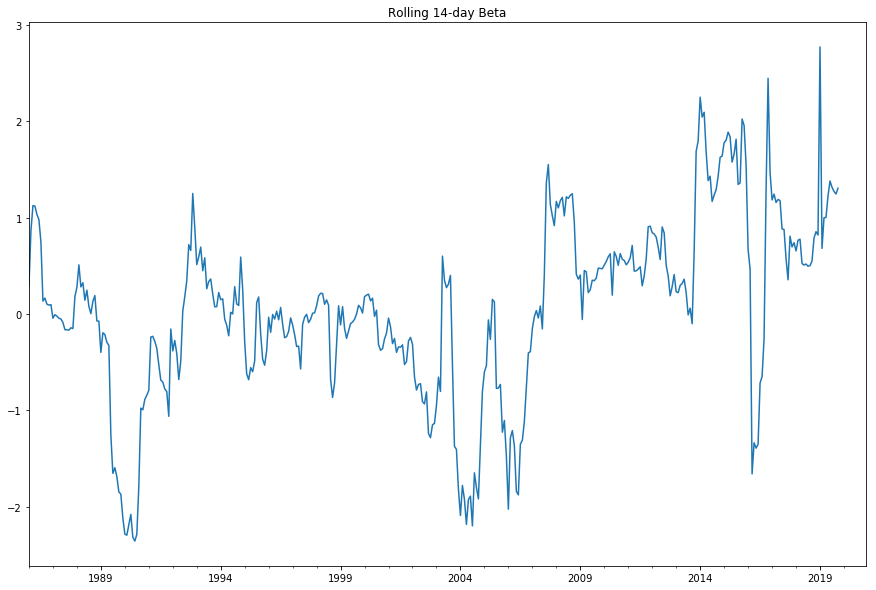

In [234]:
##Rolling beta S&P500 and WTI
rolling_cov = oil_commodities_return['sp500'].rolling(window=14).cov(oil_commodities_return["wti_mthly"])
rolling_var = oil_commodities_return['sp500'].rolling(window=14).var()
rolling_beta = rolling_cov / rolling_var
rolling_beta.plot(figsize=(15,10), title = "Rolling 14-day Beta")

In [235]:
oil_price = oil_usd_sp500[['sp500_mthly','wti_mthly']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
usd_price = oil_usd_sp500[['sp500_mthly','dxy_mthly']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")
all_price = oil_usd_sp500[['sp500_mthly','wti_mthly', 'dxy_mthly']].hvplot.line(xlabel="Date", ylabel="Monthly Closing Price")

NameError: name 'oil_usd_sp500' is not defined

From 1985 to early 2000, gold was used to hedge against market downturn. When investers were expecting a bear market, they sell shares in stock market and buy gold, causing decline in stock market indices and rise in gold prices. Hence, gold price moved in the opposite direction of S&P500 index.
This is also shown as negative (inverse) correlation until early 2000. The correlation started to change to be more positive due to creation of paper gold and commodities market in 1970's. However, it took some time for the paper gold and commdities futures market to be popularized and accessible to retial investors; therefore, the transition was not apparent until mid 2000's. The commodities market allowed traders and investors to speculate on future commodities prices. As a result, the gold price correlation began to shift to possitive territory. Since 2007, we noticed that Crude Oil has become more collerated to S&P500, possibly due to the start of oil price war.



In [ ]:
panel2.servable()

Cryptocurrencies has weak correlation to S&P500.

### Lauren's section

In [ ]:
# set and read in USA HPI (All Trans, Quarterly) 1975-2020
usa_hpi_data = pd.read_csv('DATA SOURCES/USA HPI (All Transactions, Quarterly) Jan 1975-July 2020.csv', index_col=['DATE']) # USA HPI (All Trans, Quarterly) 1975-2020
usa_hpi_data.columns=["House Price Index"]
usa_hpi_data.describe()

# calculate monthly returns
hpi_returns = usa_hpi_data.pct_change()
hpi_returns.dropna(inplace=True)
hpi_returns.head()

In [ ]:
# set and read in Interest Rate datasets
usa_inflation_data = pd.read_csv('DATA SOURCES/USA Monthly Interest Rates (1985-2020).csv',index_col='Series Description',infer_datetime_format=True) # Canada HPI by City / Province (July 1990-Dec 2020)
usa_inflation_data.reset_index(inplace=True)
column=["Date","Average Prime Rate"]
usa_inflation_data.columns =column 
usa_inflation_data.head(10)
usa_inflation_data.drop(index=[0,1,2,3,4],inplace=True)
usa_inflation_data.set_index('Date',inplace=True)
usa_inflation_data['Average Prime Rate'] = usa_inflation_data['Average Prime Rate'].astype('float')

# calculate monthly returns
prime_returns = usa_inflation_data.pct_change()
prime_returns.dropna(inplace=True)
prime_returns.head()

In [ ]:
returns_df = pd.concat([prime_returns,hpi_returns],axis='columns')
returns_df= returns_df.reset_index()
index_date=['Date','Average Prime Rate','House Price Index']
returns_df.columns = index_date
index_date = '1985-01-01'
index_date = index_date.datetime.strptime(index_date,'%Y-%m-%d.%f')
index_date = index_date.strftime("%YYYY-%mm")

# returns_df['Date'].apply(lambda d: d.datetime.strptime('%Y-%m'))
returns_df.set_index('Date',inplace=True)